# <center>MNIST - Multiclass Classification With CNN (Keras)</center>
<center><img src="files/keras-logo.png"></center>

IN this notebook, we will build Multi-class classification for the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using Convolution Neural Networks (CNN). 

The MNIST dataset is an image dataset of handwritten digits. It has has 60,000 training images and 10,000 test images, each of which are grayscale 28 x 28 sized images.It is a good beginner's dataset to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

In this notebook, we will develop a Convolutional Neural Network using the Keras library to classify these handwritten images. 

In [1]:
# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
%matplotlib inline

# NOTE: Always use a seed for random number generators, so you get same results across runs
# you can use any number as the seed 
seed = 123
np.random.seed(seed)

## Preprocessing the Images

While you can download the dataset from [this link](http://yann.lecun.com/exdb/mnist/), the Keras library already includes these digits in the `keras.datasets` module. We will load the digits from this library to save pre-processing time. I am going to use the `karas.datasets.mnist.load_data()` call. This function conveniently returns two tuples of images & labels - one for the training dataset and the other for test dataset. 

However:
* The images are not _shaped_ correctly - images tuples are shaped as `(num_samples, image_height, image_width)`, whereas we need them to be shaped as `(num_samples, image_height, image_width, num_channels)`, which is input shape of our images to the CNN.You can feed the images in any shape (e.g. `(num_samples, image_height * image_width)`, so long as you are consistent across the training & test sets!)
* The images data needs to be converted to `float32` and scaled (we will opt to scale values between 0.0 and 1.0)
* While the label tuples are shaped correctly as `(num_samples, class)`, we need to _one-hot-encode_ the labels, so our CNN output layer can correctly process it. For 10 output class, each label should be encoded into an array of shape `(1, 10)` with all zeros except at the index of the digit (e.g. 3 becomes `[0 0 0 1 0 0 0 0 0 0]` and so on).

We will handle all these transformations as in our pre-processing code below.

In [2]:
from keras.datasets.mnist import load_data
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
(train_digits, train_labels), (test_digits, test_labels) = load_data()
train_digits.shape, train_labels.shape, test_digits.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Notice that we have 60,000 images in the training set & 10,000 images in the test set. Let's randomly pick `14 images` from the `train_digits` set and see how they look.

In [4]:
rand_14 = np.random.randint(0, train_digits.shape[0],14)
sample_digits = train_digits[rand_14]
sample_labels = train_labels[rand_14]

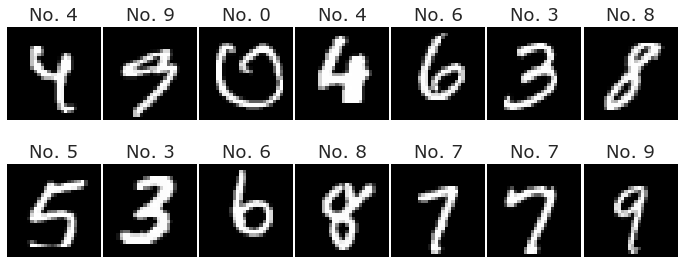

In [5]:
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01}, squeeze=True)
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

Next we will prepare the data for consumption by our Convolutional Neural Network, which we will create later. Recall that this involves:
* **Reshaping the images data** to a tensor of shape `(num_samples, image_height, image_width, num_channels)` - for our 28x28 grayscale images, this would be `(num_samples, 28, 28, 1)`, where `num_samples = 60,000` for train dataset and `num_samples = 10,000` for test dataset. An `np.reshape(...)` call will help us do just that.
* **Re-scaling the images data** to a values between 0.0 and 255.0
* **One-hot-encode** the labels - Keras provides a `to_categorical()` function in it's `utils` module, which we will use.

In [6]:
# some variables to help with pre-processing...
image_height, image_width = train_digits.shape[1], train_digits.shape[2]
num_channels = 1  # we have grayscale images
input_shape = image_height * image_width * num_channels
image_height, image_width, num_channels, input_shape

(28, 28, 1, 784)

In [7]:
# re-shape the images data
train_data = np.reshape(train_digits,(train_digits.shape[0], image_height, image_width, num_channels))
test_data = np.reshape(test_digits,(test_digits.shape[0],image_height, image_width, num_channels))
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
# re-scale the images data to values between (0.0 and 255.0] (i.e. 0.0 <= value < 255.0)
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

In [9]:
# one-hot-encode the labels
num_classes = 10
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((60000, 10), (10000, 10))

In [10]:
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

Next we will split the _training set_ into _training & cross-validation_ sets. We will _train_ my model _on the training set_ & _evaluate performance on validation set_ during the training process (i.e. cross-validate). I will _set aside the test-set_ for a final test run, after I am satisfied with my metrics from training. This way, I always have some data that the model has never seen. This helps me avoid overfitting to some extent. We will set aside 10% of the training_set as the validation set.<br/>
Of course, to ensure randomness in selecting the data, we will also shuffle the training set (5 times!).

In [11]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels.shape

((54000, 28, 28, 1),
 (54000, 10),
 (6000, 28, 28, 1),
 (6000, 10),
 (10000, 28, 28, 1),
 (10000,))

In [12]:
# some globals
num_features = train_data.shape[1]
num_epochs = 5
batch_size = 64

## Helper Functions

In [13]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [14]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

## Keras Model Development

Our Keras model will have the following configuration:
* 3 `Conv2d` layers, each with 32, 64 and 64 filters and `relu` activation functions and a `(3,3)` kernel size, and `padding='same'`
* We follow each Conv2d layer with a `MaxPooling2d` layer with a `(2,2)` pool size
* Finally, we have a `Dense` layer with 512 nodes and `relu` activation.
* The output `Dense` layer has 10 nodes (for the 10 digits) and a `softmax` activation function (for a a multi-class classification problem)
* We use the `categorical-crossentropy` loss and the `adam` optimizer.

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
def build_model():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model = build_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
________________________________________________________

In [ ]:
start_time = time.time()
history = model.fit(train_data2, train_labels_cat2, epochs=15, batch_size=64,
                    validation_data=(val_data, val_labels_cat))
end_time = time.time()
print_time_taken(start_time, end_time)

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 105s - loss: 0.1765 - acc: 0.9440 - val_loss: 0.0578 - val_acc: 0.9822
Epoch 2/15
 8960/54000 [===>..........................] - ETA: 82s - loss: 0.0525 - acc: 0.9833

**NOTE:** With this CNN, we get a training accuracy of 99.7% (and validation accuracy of 99.3%) - see last line of output above. 

Next, let us view plots of train & validation accuracies vs epochs and train & validation losses vs epochs. We will use the `show_plots()` helper function coded above which presents these charts in a 1x2 grid.

In [ ]:
show_plots(history.history)

The plots suggests that this Keras model is overfitting the training data after 3-4 epochs: 
* We can see from the top-left plot that the training loss is falling smoothly towards zero, however the test loss falls for some epochs and then rises somewhat after the 4th epoch.
* Also in the accuracy plots (top-right), we observe that the training accuracu rises towards 100%, whereas the validation accuracy flattens out after around 4 epochs - at a value around 99%. 
* This is a typical behavior of an overfitting model. However our validation loss is not significantly lesser than our training loss, indicating that the model is overfitting only slightly.

Let us see how our model is performing against test data that it has not _seen_ so far. 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels_cat, batch_size=batch_size)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

**Observation:** We get a test accuracy of 99.3% with the test data, which is a great metric! Our model is generalizing well (i.e. the accuracy score is good on data that it has not seen before). 
## Predictions
Next, let us run some predictions using this model & test data.

In [ ]:
# now let's predict the outcomes of our model
kr_test_pred = model.predict(test_data)
# NOTE: each member of kr_test_pred would be a (1,10) array 
# each index of the array holds the probability that the model thinks it is the digit at that offset
# example for digit [??] -> [???]
# The index which holds the maximum probability value is the predictioon

In [ ]:
# view first 20 - both predicted & actual
np.argmax(kr_test_pred, axis=1)[:25]

In [ ]:
np.argmax(test_labels_cat,axis=1)[:25]

In [ ]:
# how many mismatches?
(np.argmax(kr_test_pred, axis=1) != np.argmax(test_labels_cat,axis=1)).sum()

So, we have around 80 of 10,000 mismatched records in our test data. Not bad.

In [ ]:
#save our model
model.save('./model_states/keras_mnist.h5')

# Summary
* In this workbook we created a CNN with Keras to classify the MNIST digits.
* We were able to achieve test accuracy of 99%, though our model was overfitting slightly.

# <center> - - END - - </center>